In [1]:
# Import libraries

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit import IBMQ, Aer
from qiskit.quantum_info import Statevector, partial_trace, random_unitary
from numpy.random import randint, rand
from IPython.display import clear_output
from qiskit.extensions import Initialize
from statistics import mean, stdev, variance
from qiskit.providers.aer.noise import NoiseModel, device
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt
import time
from random import choice, sample
import random
IBMQ.save_account('b8880574a4a7e50ac6eb5ca65974a70cdc06ce7c4a59c276b0ffd0c44d44088035bd9b9ed6f002d33ed3380f32bcbae8aac026eec30de52943a6f19375e3b557')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
shots = 1024
sim = provider.get_backend('ibmq_qasm_simulator')
backend = provider.get_backend('ibmq_lima')
state_vector_sim = Aer.get_backend('statevector_simulator')

configrc.store_credentials:WARNING:2023-05-17 04:52:13,161: Credentials already present. Set overwrite=True to overwrite.


In [2]:
#Building Noise Model
backend = provider.get_backend('ibmq_lima')

# Build noise model from backend properties
noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

actualbackend_properties = backend.properties()
readout_errors = device.basic_device_readout_errors(actualbackend_properties)
gate_errors = device.basic_device_gate_errors(actualbackend_properties)
error_values = device.readout_error_values(actualbackend_properties)
gate_param_values = device.gate_param_values(actualbackend_properties)
gate_error_values = device.gate_error_values(actualbackend_properties)
gate_length_values = device.gate_length_values(actualbackend_properties)
thermal_relaxation_values = device.thermal_relaxation_values(actualbackend_properties)

created_noise_model = NoiseModel()
for qubit, error in readout_errors:
    created_noise_model.add_readout_error(error, qubit)
for instr, qubit, error in gate_errors:
    created_noise_model.add_quantum_error(error, instr, qubit)
created_noisy_sim = QasmSimulator(noise_model = created_noise_model)

In [3]:
#function to create pure entangled states

def pure_estate(circuit,q0,q1):
    u1 = random_unitary(2)
    circuit.append(u1,[q0])
    circuit.cx(q0,q1)
    
    return circuit       

In [4]:
###### Generating a random message

n=int(input("Length of message:"))
message = np.random.randint(2, size = n)
print(message)
nd=int(input("Number of decoy bits to be inserted:"))

Length of message:15
[1 1 1 0 1 0 0 1 1 1 1 1 0 0 1]
Number of decoy bits to be inserted:10


In [5]:
#Generating a list of possible states

states=['0', '1', '+', '-']

In [6]:
#Generating set of decoy photons

dq_st=[]
def gen_decoy(i):
    dqu=QuantumCircuit(1)
    if i=='1' or i=='-':
        dqu.x(0)
    if i=='+' or i=='-':
        dqu.h(0)
    return dqu
    #dqu.save_statevetor()
    #dq.append(dqu)
    #result = state_vector_sim.run(dqu).result()
    #sv = result.get_statevector()
    #dq_st.append(sv)

In [7]:
#Attacks 0 ="", 1="EaM Attack", 2="IaR Attack", 3="DoS Attack"


#Entangle and measure attack
def EaM_attack_z(qc):
    """ Create entanglement with qubits in the circuit. """
    num_qubits = qc.num_qubits
    if num_qubits==1:
        e = QuantumRegister(1)
        e_cl = ClassicalRegister(1)
        qc.add_register(e)
        qc.add_register(e_cl)
        qc.cx(0, num_qubits)
        qc.measure(num_qubits, 0)
    else:
        e = QuantumRegister(1)
        qc.add_register(e)
        qc.cx(num_qubits-1,num_qubits)
        qc.measure(num_qubits, 0)

def EaM_attack_x(qc):
    """ Create entanglement with qubits in the circuit. """
    num_qubits = qc.num_qubits
    if num_qubits==1:
        e = QuantumRegister(1)
        e_cl = ClassicalRegister(1)
        qc.add_register(e)
        qc.add_register(e_cl)
        qc.cx(0, num_qubits)
        qc.h(num_qubits)
        qc.measure(num_qubits, 0)
        qc.h(num_qubits)
    else:
        e = QuantumRegister(1)
        qc.add_register(e)
        qc.cx(num_qubits-1,num_qubits)
        qc.h(num_qubits)
        qc.measure(num_qubits, 0)
        qc.h(num_qubits)
        
#Intercept and resend attack
def IaR_attack_z(qc):
    """ Intercepts the qubits with measurement in Hadamard basis. """
    #print("Perform IaR attack")
    num_qubits = qc.num_qubits
    if num_qubits==1:
        e_cl = ClassicalRegister(1)
        qc.add_register(e_cl)
    for i in range(qc.num_qubits):
        qc.measure(i, qc.num_clbits-1)

def IaR_attack_x(qc):
    """ Intercepts the qubits with measurement in Hadamard basis. """
    #print("Perform IaR attack")
    num_qubits = qc.num_qubits
    if num_qubits==1:
        e_cl = ClassicalRegister(1)
        qc.add_register(e_cl)
    for i in range(qc.num_qubits):
        qc.h(i)
        qc.measure(i, qc.num_clbits-1)
        qc.h(i)

#DoS attack    
def DoS_attack(qc):
    """ Randomly applies identity on Alice's qubit """
    #print("Perform DOS attack")
    num_qubits = qc.num_qubits
    if num_qubits==1:
        e_cl = ClassicalRegister(1)
        qc.add_register(e_cl)
    # 𝜃,𝜙,𝜆 varies between 0 and 2𝜋
    theta  = 2 * pi * rand()
    phi = 2 * pi * rand()
    lamb = 2 * pi * rand()
    qc.u(theta, phi, lamb, random.randrange(num_qubits))

In [8]:
#function to apply any attack

def do_attack(qcl):
    print("Types of attacks: 1. Entanglement and Measurement Attack. 2. Intercept and Resend Attack 3. Denial of Service Attack.")
    attack=input("\nEnter the type of attack you wish to implement:")
    if attack == '1':
        for i in range(n+nd):
            EaM_lst=[EaM_attack_z,EaM_attack_x]
            choice(EaM_lst)(qcl[i])
                        
    elif attack == '2':
        for i in range(n+nd):
            IaR_lst=[IaR_attack_z,IaR_attack_x]
            choice(IaR_lst)(qcl[i]) 
                        
    elif attack == '3':
        for i in range(n+nd):
            DoS_attack(qcl[i])
    
    return attack


#function to apply EaM attack
def do_attack1(qcl):
    for i in range(n+nd):
        EaM_lst=[EaM_attack_z,EaM_attack_x]
        choice(EaM_lst)(qcl[i])
    return '1'

        
#function to apply IaR attack        
def do_attack2(qcl):
    for i in range(n+nd):
        IaR_lst=[IaR_attack_z,IaR_attack_x]
        choice(IaR_lst)(qcl[i]) 
    return '2'
        
#function to apply DoS attack
def do_attack3(qcl):
    for i in range(n+nd):
        DoS_attack(qcl[i])
    return '3'

In [9]:
#Step1:Creating n pure entangled states
def create_pest(m):
    pk=[]
    for i in range(m):
        qr = QuantumRegister(2, 'qb')
        cr = ClassicalRegister(1, 'cb')
        circuit = QuantumCircuit(qr,cr)
        state=(pure_estate(circuit,qr[0],qr[1]))
        pk.append(state)
        #display(pk[i].draw('mpl'))
    return pk

private_key0=create_pest(n)
#check eavesdropping by adding decoy photons at random position and printing the positions

def create_pkd(private_key,n,nd):
    pkd=[]
    for i in range(n):
        pkd.append(private_key[i].copy())
    lst=[x for x in range(n+nd)]
    pos1=sample(lst,nd)
    pos1.sort()
    rdq1=[]
    rdq_st1=[]
    for i in pos1:
        decoy_st1=choice(states)
        decoy1=gen_decoy(decoy_st1)
        rdq1.append(decoy1)
        rdq_st1.append(decoy_st1)
        decoy12=decoy1.copy()
        pkd.insert(i,decoy12)
    print(pos1)
    return pkd,rdq_st1,pos1

pkd0,rdq_st10,pos10=create_pkd(private_key0,n,nd)

[0, 3, 4, 6, 7, 10, 11, 14, 15, 16]


In [10]:
#for i in range(nd):
    #result = state_vector_sim.run(rdq1[i]).result()
    #sv = result.get_statevector()
    #print(sv)
for i in range(nd):
    print(rdq_st10[i])

-
-
-
0
0
+
1
1
1
1


In [11]:
#Applying attack of choice on the sequence of pure entangled states with decoy photons

att1=do_attack3(pkd0)

In [12]:
def noisy_meas_err_func(cc,rdq_st,j,shots,flag):
    err=0
    err_c=0
    a=list(cc.keys())
    a.sort()
    if '0' in cc and '1' not in cc:
        if flag==0:
            if a[0] != '0':
                err=shots
                err_c+=1
        else:
            if rdq_st[j]=='-':
                err=shots
                err_c+=1
    elif '1' in cc and '0' not in cc:
        if flag==0:
            if a[0] != '1':
                err=shots
                err_c+=1
        else:
            if rdq_st[j]=='+':
                err=shots
                err_c+=1  
    if '0' in cc and '1' in cc:
        if flag == 0:
            if a[0] == rdq_st[j]:
                err=cc['1']
                if cc['1']>cc['0'] or abs(cc['0']-cc['1'])<600:
                    err_c += 1
            elif a[1] == rdq_st[j]:
                err = cc['0']
                if cc['0']>cc['1'] or abs(cc['0']-cc['1'])<600:
                    err_c += 1
        elif flag==1:
            if rdq_st[j]=='+':
                err=cc['1']
                if abs(cc['0']-cc['1'])<600:
                    err_c += 1
            elif rdq_st[j]=='-':
                err=cc['0']
                if abs(cc['0']-cc['1'])<600:
                    err_c += 1
    
    return err,err_c

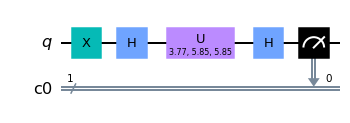

The measurements of the decoy photon at position 0 after the attack is: {'0': 949, '1': 75}


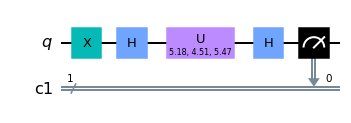

The measurements of the decoy photon at position 3 after the attack is: {'0': 898, '1': 126}


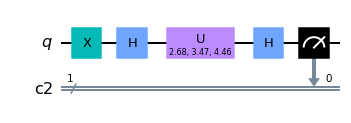

The measurements of the decoy photon at position 4 after the attack is: {'0': 786, '1': 238}


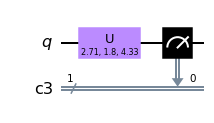

The measurements of the decoy photon at position 6 after the attack is: {'1': 951, '0': 73}


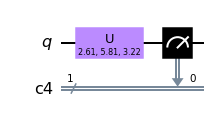

The measurements of the decoy photon at position 7 after the attack is: {'1': 923, '0': 101}


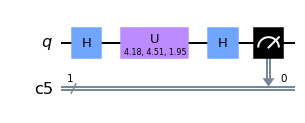

The measurements of the decoy photon at position 10 after the attack is: {'0': 945, '1': 79}


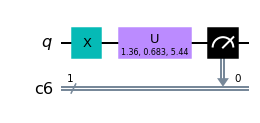

The measurements of the decoy photon at position 11 after the attack is: {'1': 612, '0': 412}


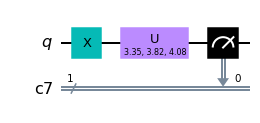

The measurements of the decoy photon at position 14 after the attack is: {'0': 1003, '1': 21}


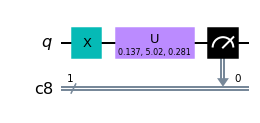

The measurements of the decoy photon at position 15 after the attack is: {'1': 992, '0': 32}


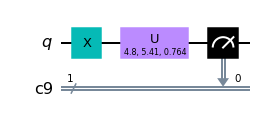

The measurements of the decoy photon at position 16 after the attack is: {'0': 482, '1': 542}
Error rate in measuring decoy photons: 63.623046875 %
The number of mismatched decoy photons is 6 and the error rate of trasmitting decoy photons: 60.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 3.028158187866211 seconds

Eavesdropper detected.


In [13]:
#Measuring the decoy photons inserted in sequence of pure entangled states in respective bases and finiding the errors

errors_for_first_check0=[]
errors_count_for_first_check0=[]
def check_eavesdropper1(pkd,rdq_st1,errors_for_first_check0,errors_count_for_first_check0,pos1):
    j=0
    err1=0
    err_rate1=0.0
    err_flag1=0
    err_count1=0
    err_count_rate1=0.0
    time01 = time.time()
    for i in pos1:
        flag=0
        if rdq_st1[j]=='+' or rdq_st1[j]=='-':
            pkd[i].h(0)
            flag=1
        pkd[i].measure(0,0)
        rslt1 = execute(pkd[i], backend=created_noisy_sim, shots=shots).result()
        cc1 = rslt1.get_counts()
        k=list(cc1.keys())
        k.sort()
        display(pkd[i].draw('mpl'))
        print("The measurements of the decoy photon at position",i,"after the attack is:",cc1)       
        err1,err_flag1=noisy_meas_err_func(cc1,rdq_st1,j,shots,flag)
        err_count1+=err_flag1
        j=j+1
        err_rate1=err_rate1+float((err1/shots)*100)
    time_1 = time.time() - time01
    hr1 = time_1//3600
    time_1 %= 3600
    err_rate1=float(err_rate1/nd)
    err_count_rate1=float(( err_count1/nd)*100)
    errors_for_first_check0.append(err_rate1)
    errors_count_for_first_check0.append(err_count_rate1)
    return  err_count1,err_count_rate1,err_rate1,hr1,time_1

err_count1,err_count_rate1,err_rate1,hr1,time_1=check_eavesdropper1(pkd0,rdq_st10,errors_for_first_check0,errors_count_for_first_check0,pos10)
print(f"Error rate in measuring decoy photons: {err_rate1} %")
print(f"The number of mismatched decoy photons is {err_count1} and the error rate of trasmitting decoy photons: {err_count_rate1} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr1)} hours {int(time_1//60)} minutes {time_1%60} seconds')
if err_count1!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

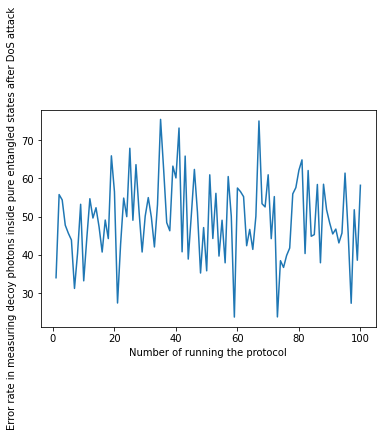

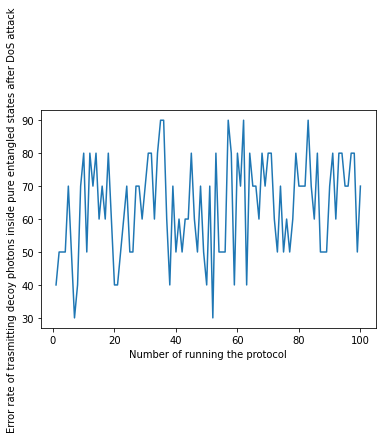

In [14]:
#DoS Attack

s=100

errors_for_first_check3=[]
errors_count_for_first_check3=[]
for i in range(s):
    pkd,rdq_st3,pos3=create_pkd(private_key0,n,nd)
    do_attack3(pkd)
    err_count3,err_count_rate3,err_rate3,hr3,time_3=check_eavesdropper1(pkd,rdq_st3,errors_for_first_check3,errors_count_for_first_check3,pos3)

#print(errors_for_first_check3)

clear_output()
plt.plot(range(1,s+1),errors_for_first_check3)
plt.xlabel('Number of running the protocol')
plt.ylabel('Error rate in measuring decoy photons inside pure entangled states after DoS attack')
plt.show()

plt.plot(range(1,s+1),errors_count_for_first_check3)
plt.xlabel('Number of running the protocol')
plt.ylabel('Error rate of trasmitting decoy photons inside pure entangled states after DoS attack')
plt.show()

In [15]:
#Step2:Creating a sequence of travelling qubits in Z basis

def create_tq(msg):
    tt=[]
    for i in msg:
        t=QuantumCircuit(QuantumRegister(1))
        if i==0:
            tt.append(t)
        else:
            t.x(0)
            tt.append(t)
    return tt


tq0=create_tq(message)        

In [16]:
#Step3: Encrypting the message using CNOT gate

def encrypt_mes(pk,tt,m):
    for i in range(m):       
        pk[i].add_register(*tt[i].qregs)
        pk[i].barrier()
        pk[i]=pk[i]+tt[i]
        #display(pk[i].draw('mpl'))
        pk[i].cx(0,2)
        

encrypt_mes(private_key0,tq0,n)


#inserting decoy photons in the sequence of travelling photons to check for eavesdropping
def insert_decoys2(private_key,nd):
    rdq_st2=[]
    lst=[x for x in range(n+nd)]
    pos2=sample(lst,nd)
    pos2.sort()
    rdq2=[]
    for i in pos2:
        decoy_st2=choice(states)
        decoy2=gen_decoy(decoy_st2)
        rdq2.append(decoy2)
        rdq_st2.append(decoy_st2)
        decoy22=decoy2.copy()
        private_key.insert(i,decoy22)
    print(pos2)
    return private_key,rdq_st2,pos2

private_key0,rdq_st20,pos20=insert_decoys2(private_key0,nd)

[0, 5, 7, 10, 13, 15, 16, 20, 23, 24]


<ipython-input-16-1da6b4dc2c54>:7: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  pk[i]=pk[i]+tt[i]


In [17]:
for i in range(nd):
    print(rdq_st20[i])

-
1
+
1
+
1
1
-
+
1


In [18]:
#Applying attack of choice on the sequence of travelling photons with decoy photons

att2=do_attack3(private_key0)

In [19]:
#Measuring the travelling photons to measure information leak

mssg_info_leak=[]
def measure_info_leak(pk,mssg_info_leak,pos2,mssg):
    j=0
    mssg_leak_c=0
    mssg_leak_rate=0.0
    time0 = time.time()
    for i in range(n+nd):
        if i not in pos2:
            rslt = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
            cc = rslt.get_counts()
            display(pk[i].draw('mpl'))
            print("The measurements of the travelling photons after the attack is:",cc)
            rs=-1
            if '0' in cc and '1' not in cc:
                rs=0
            elif '1' in cc and '0' not in cc:
                rs=1
            if '0' in cc and '1' in cc:
                if cc['0']>cc['1'] and abs(cc['0']-cc['1'])>200:
                    rs=0
                if cc['0']<cc['1'] and abs(cc['0']-cc['1'])>200:
                    rs=1
            print(rs,mssg[j])
            if (rs==mssg[j]):
                mssg_leak_c+=1
            j=j+1
    time_ = time.time() - time0
    hr = time_//3600
    time_ %= 3600
    mssg_leak_rate=float((mssg_leak_c/n)*100)
    mssg_info_leak.append(mssg_leak_rate)
    return mssg_leak_c,mssg_leak_rate,hr,time_


if att2=='1' or att2=='2':
    mssg_leak_c,mssg_leak_rate,hr,time_=measure_info_leak(private_key0,mssg_info_leak,pos20,message)
    print(f"The number of message bits leaked is {mssg_leak_c} and the rate of message being leaked: {mssg_leak_rate} %")
    print(f'Time taken to measure {n} travelling photons entangled with pure entangled states: {int(hr)} hours {int(time_//60)} minutes {time_%60} seconds')

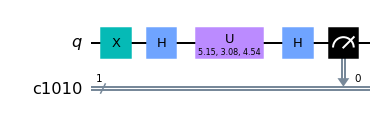

The measurements of the decoy photon at position 0 after the attack is: {'1': 565, '0': 459}


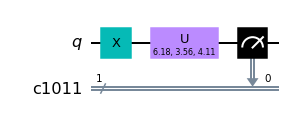

The measurements of the decoy photon at position 5 after the attack is: {'1': 985, '0': 39}


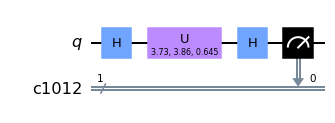

The measurements of the decoy photon at position 7 after the attack is: {'1': 62, '0': 962}


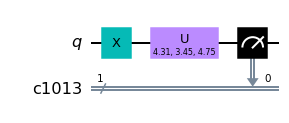

The measurements of the decoy photon at position 10 after the attack is: {'0': 745, '1': 279}


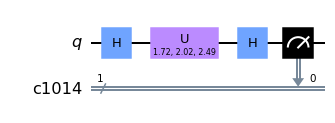

The measurements of the decoy photon at position 13 after the attack is: {'0': 228, '1': 796}


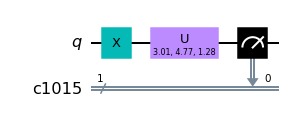

The measurements of the decoy photon at position 15 after the attack is: {'0': 1012, '1': 12}


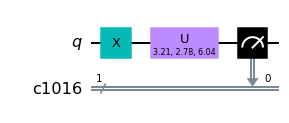

The measurements of the decoy photon at position 16 after the attack is: {'0': 1014, '1': 10}


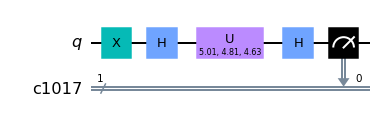

The measurements of the decoy photon at position 20 after the attack is: {'0': 1011, '1': 13}


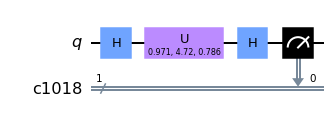

The measurements of the decoy photon at position 23 after the attack is: {'0': 865, '1': 159}


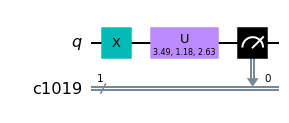

The measurements of the decoy photon at position 24 after the attack is: {'0': 993, '1': 31}
Error rate in measuring decoy photons: 61.42578125 %
The number of mismatched decoy photons is 6 and the error rate of trasmitting decoy photons: 60.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 3.248467206954956 seconds

Eavesdropper detected.


In [20]:
#Measuring the decoy photons inserted in sequence of travelling photons in respective bases and finiding the errors

errors_for_second_check0=[]
def check_eavesdropper2(pk,rdq_st2,errors_for_second_check,pos2):
    j=0
    err2=0
    err_rate2=0.0
    err_flag2=0
    err_count2=0
    err_count_rate2=0.0
    time02 = time.time()
    for i in pos2:
        flag=0
        if rdq_st2[j]=='+' or rdq_st2[j]=='-':
            pk[i].h(0)
            flag=1
        pk[i].measure(0,0)
        rslt2 = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
        cc2 = rslt2.get_counts()
        m=list(cc2.keys())
        m.sort()
        display(pk[i].draw('mpl'))
        print("The measurements of the decoy photon at position",i,"after the attack is:",cc2)       
        err2,err_flag2=noisy_meas_err_func(cc2,rdq_st2,j,shots,flag)
        err_count2+=err_flag2
        j=j+1
        err_rate2=err_rate2+float((err2/shots)*100)
    time_2 = time.time() - time02
    hr2 = time_2//3600
    time_2 %= 3600
    err_rate2=float(err_rate2/nd)
    err_count_rate2=float((err_count2/nd)*100)
    errors_for_second_check.append(err_rate2)
    return err_count2,err_count_rate2,err_rate2,hr2,time_2

err_count2,err_count_rate2,err_rate2,hr2,time_2=check_eavesdropper2(private_key0,rdq_st20,errors_for_second_check0,pos20)
print(f"Error rate in measuring decoy photons: {err_rate2} %")
print(f"The number of mismatched decoy photons is {err_count2} and the error rate of trasmitting decoy photons: {err_count_rate2} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr2)} hours {int(time_2//60)} minutes {time_2%60} seconds')
if err_count2!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

In [21]:
#Step 4: Decrypting the message using CNOT gate

def decrypt_mes(pk,m,pos2):
    for i in range(m):
        if i not in pos2:
            pk[i].cx(1,2)
            pk[i].barrier()
        
decrypt_mes(private_key0,n+nd,pos20)

In [22]:
def cal_error_and_res(fm,mssg,j):
    error=0
    wrong_mssg=0
    a=list(fm.keys())
    a.sort()
    res=-1
    if '0' in fm and '1' not in fm:
        res=0
    elif '1' in fm and '0' not in fm:
        res=1
    if '0' in fm and '1' in fm:
        if fm['0']>fm['1'] and abs(fm['0']-fm['1'])>600:
            res=0
        elif fm['0']<fm['1'] and abs(fm['0']-fm['1'])>600:
            res=1
        if int(a[0])==mssg[j]:
            error=fm['1']
        elif int(a[1])==mssg[j]:
            error=fm['0']
    if res!=mssg[j]:
        wrong_mssg=1
    return res,error,wrong_mssg

In [23]:
#Measuring the travelling qubit in Z basis

error_lst=[]
errors_in_mssg=[]
def measure_tq(pk,error_lst,errors_in_mssg,mssg,pos2):
    error=0
    error_rate=0.0
    error_in_mssg=0
    error_in_mssg_rate=0.0
    result2=[]
    time03 = time.time()
    j=0
    for i in range(n+nd):
        if i not in pos2:
            pk[i].measure(2,0)
            pk[i].barrier()
            result = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
            noisy_counts=result.get_counts()
            print(noisy_counts)
            res,error,wrong_mssg=cal_error_and_res(noisy_counts,mssg,j)
            error_in_mssg+=wrong_mssg
            error_rate = error_rate + float((error/shots)*100)
            result2.append(res)
            #display(private_key[i].draw('mpl'))
            j+=1
    time_3 = time.time() - time03
    hr3 = time_3//3600
    time_3 %= 3600
    error_in_mssg_rate=float((error_in_mssg/n)*100)
    error_rate = float(error_rate/n)
    error_lst.append(error_rate)
    errors_in_mssg.append(error_in_mssg_rate)
    print(f"The number of mismatched message photons is {error_in_mssg} and the amount of mismatched message photons:{error_in_mssg_rate} %")
    print(f"Error rate in measuring message photons: {error_rate} %")
    print(f'Time taken to measure {n} message photons: {int(hr3)} hours {int(time_3//60)} minutes {time_3%60} seconds')
    return result2

final_res=measure_tq(private_key0,error_lst,errors_in_mssg,message,pos20)     


{'0': 927, '1': 97}
{'1': 952, '0': 72}
{'1': 941, '0': 83}
{'1': 896, '0': 128}
{'1': 771, '0': 253}
{'0': 800, '1': 224}
{'1': 285, '0': 739}
{'1': 633, '0': 391}
{'0': 623, '1': 401}
{'0': 651, '1': 373}
{'0': 471, '1': 553}
{'1': 947, '0': 77}
{'0': 924, '1': 100}
{'0': 988, '1': 36}
{'0': 921, '1': 103}
The number of mismatched message photons is 10 and the amount of mismatched message photons:66.66666666666666 %
Error rate in measuring message photons: 39.127604166666664 %
Time taken to measure 15 message photons: 0 hours 0 minutes 1.9907419681549072 seconds
